# Compare ocean dynamics (zos) from CMIP5 and CMIP6 with sea level budgets

In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

sys.path.append('../code/')
import mod_loc as loc
import mod_postpro as pp

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
import dask.config as dc
dc.set(**{'array.slicing.split_large_chunks': True})

In [23]:
cmip_data_dir = '../outputs/'

path_fig = ('/Users/dewilebars/Projects/KNMIClimateScenarios2021-2023/'+
            '2021_KNMIsignal_21/projections/figures/')

In [5]:
path_slb = '/Users/dewilebars/Projects/SLBudget/outputs/'
budget_df = pd.read_csv(path_slb+
                        'slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv')
budget_df = budget_df.set_index('time')
budget_df.iloc[-10:]

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
2009,8.016171,3.552064,2.508173,1.105000,1.194167,0.370833,0.088333,0.188333,0.892339,-1.090116,-0.792955,5.600000
2010,8.003000,4.389224,2.463398,1.141833,1.259167,0.446667,0.100833,0.367500,0.735257,-2.354945,-0.545934,4.766667
2011,9.988545,4.781370,2.577349,1.178667,1.286667,0.466667,0.103333,-0.016667,0.555900,1.935137,-2.879877,8.250000
2012,7.799622,2.654583,2.741227,1.215500,1.289167,0.491667,0.115833,0.316667,0.374518,0.184546,-1.584085,7.300000
2013,5.084063,3.520389,2.934533,1.252333,1.345833,0.561667,0.125000,0.511667,0.211591,-3.656733,-1.722219,4.800000
2014,8.918411,4.540554,3.090276,1.289167,1.401667,0.626667,0.130833,0.240000,0.085516,-2.865864,0.379595,8.900000
2015,10.947002,3.255820,3.297743,1.326000,1.474167,0.721667,0.144167,0.465000,0.010529,3.470097,-3.218186,11.483333
2016,7.910991,3.790802,3.270519,1.362833,1.528333,0.692500,0.157500,0.675000,-0.004905,-1.330948,-2.230644,9.933333
2017,13.661746,5.137556,3.428105,1.399667,1.600000,0.708333,0.165000,0.130833,0.040957,3.277656,-2.226363,13.450000


In [6]:
budget_LocOcean = (budget_df['LocSteric'] + budget_df['Nodal'] + 
                   budget_df['Wind'] +  budget_df['Pressure'])
budget_LocOcean = budget_LocOcean - budget_LocOcean.loc[1986:2005].mean()

budget_LocSteric_Wind = (budget_df['LocSteric'] + budget_df['Wind'])
budget_LocSteric_Wind = (budget_LocSteric_Wind 
                         - budget_LocSteric_Wind.loc[1986:2005].mean())


In [7]:
cmip5_zos = pp.read_zos_ds(cmip_data_dir, 'cmip5', 'rcp45')
cmip6_zos = pp.read_zos_ds(cmip_data_dir, 'cmip6', 'ssp245')

In [8]:
#regions: dutch_coast, north_sea, knmi14_reg
lon_min, lon_max, lat_min, lat_max = pp.define_area('knmi14_reg')

cmip6_df = pp.ds2df(cmip6_zos, lon_min, lon_max, lat_min, lat_max, 1979, 2030)
cmip5_df = pp.ds2df(cmip5_zos, lon_min, lon_max, lat_min, lat_max, 1979, 2030)

In [9]:
cmip6_mean_df = cmip6_df.mean(axis=1)
cmip5_mean_df = cmip5_df.mean(axis=1)

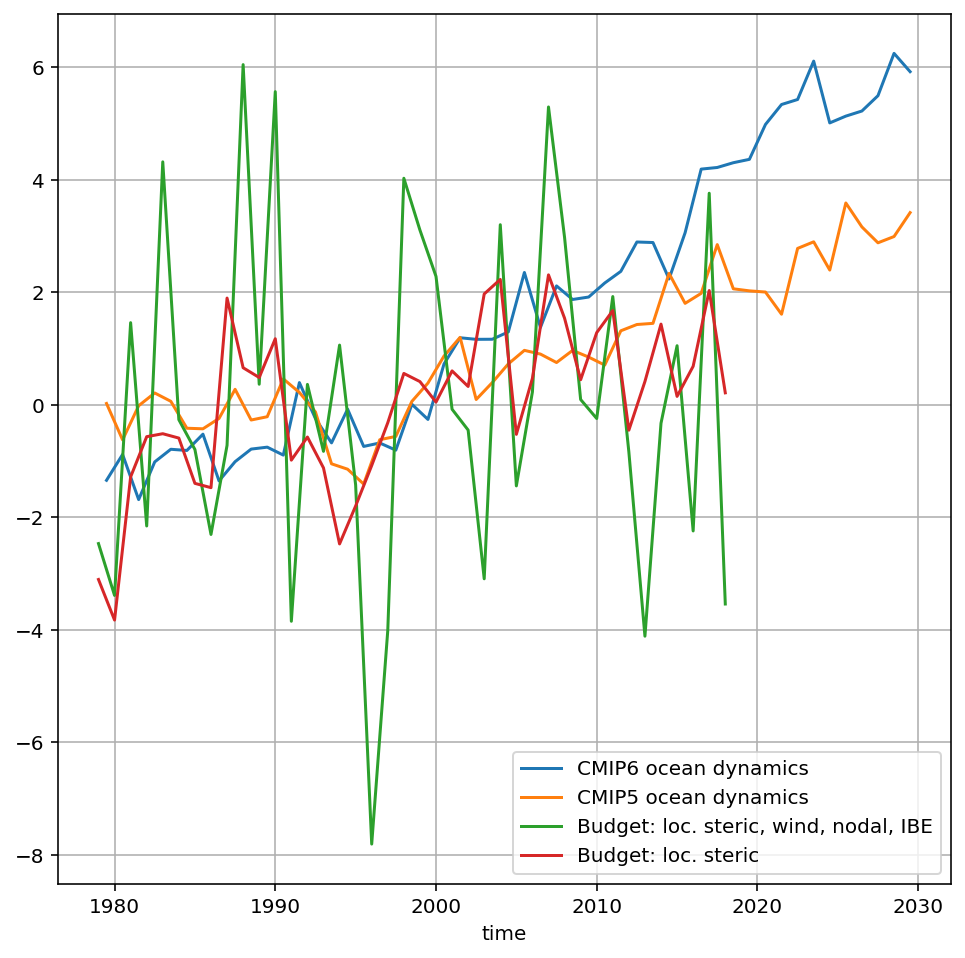

In [20]:
fig, ax = plt.subplots(figsize=(8,8))

cmip6_mean_df.plot(legend=True, label='CMIP6 ocean dynamics')
cmip5_mean_df.plot(legend=True, label='CMIP5 ocean dynamics')
budget_LocOcean.plot(legend=True, label='Budget: loc. steric, wind, nodal, IBE')
(budget_df['LocSteric']- budget_df['LocSteric'].loc[1986:2005].mean() ).plot(legend=True, label='Budget: loc. steric')

ax.grid(True)

#plt.savefig(path_fig+'comp_ocean_dynamics.pdf', dpi=150)

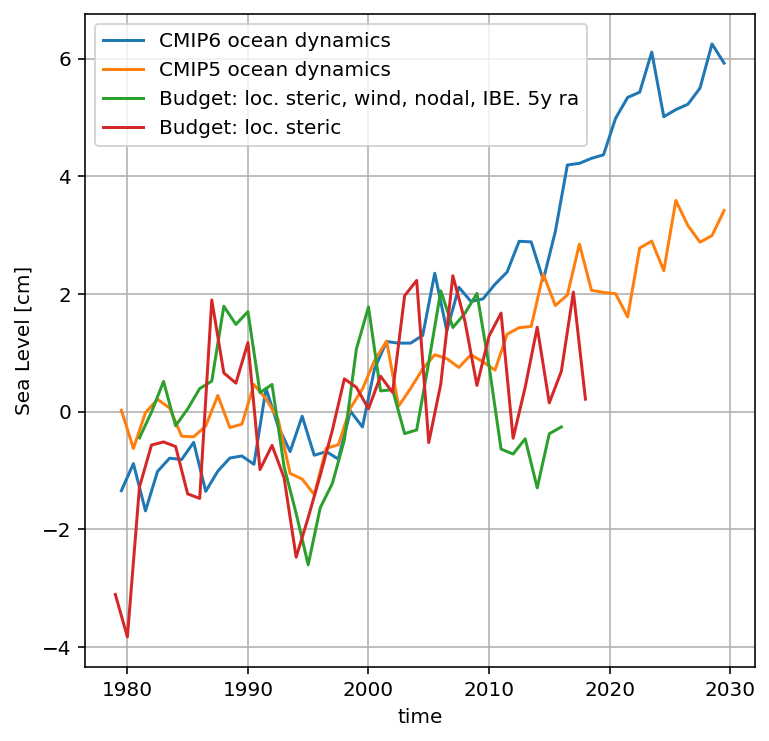

In [24]:
fig, ax = plt.subplots(figsize=(6,6))

cmip6_mean_df.plot(legend=True, label='CMIP6 ocean dynamics')
cmip5_mean_df.plot(legend=True, label='CMIP5 ocean dynamics')
budget_LocOcean.rolling(5, center=True).mean().plot(legend=True, label='Budget: loc. steric, wind, nodal, IBE. 5y ra')
(budget_df['LocSteric']- budget_df['LocSteric'].loc[1986:2005].mean() ).plot(legend=True, label='Budget: loc. steric')

ax.set_ylabel('Sea Level [cm]')
ax.grid(True)

plt.savefig(path_fig+'comp_ocean_dynamics_smoother.pdf', dpi=150)

### Compute the mismatch between CMIP6 and observations to define trend bias or scaling factor that are applied make bias corrected projections

In [11]:
def print_trend_budget_model(start_y, end_y, budget_df, model_df):
    
    budget_LocSteric_Wind = budget_df['LocSteric']+budget_df['Wind']
    trend_LocSteric_Wind = linregress(np.arange(start_y,end_y+1), 
                                      budget_LocSteric_Wind.loc[start_y:end_y])
    trend_LocSteric = linregress(np.arange(start_y,end_y+1), 
                                budget_df['LocSteric'].loc[start_y:end_y])
    trend_Wind = linregress(np.arange(start_y,end_y+1), 
                            budget_df['Wind'].loc[start_y:end_y])
    trend_Press = linregress(np.arange(start_y,end_y+1), 
                            budget_df['Pressure'].loc[start_y:end_y])

    trend_model = linregress(np.arange(start_y,end_y+1), 
                            model_df.loc[start_y:end_y+1])

    bias_dynamics = linregress(np.arange(start_y,end_y+1), 
                               model_df.loc[start_y:end_y+1].values-
                               budget_LocSteric_Wind.loc[start_y:end_y].values)
    
    scaling_fac = trend_LocSteric_Wind.slope/trend_model.slope
    scaling_fac_nowind = trend_LocSteric.slope/trend_model.slope
    
    print(f'Trends (mm/yr) for period {start_y}-{end_y}')
    print('Budget:')
    print(f'  Local steric and wind: {trend_LocSteric_Wind.slope*10}')
    print(f'  Local steric: {trend_LocSteric.slope*10}')
    print(f'  Wind: {trend_Wind.slope*10}')
    print(f'  Press: {trend_Press.slope*10}')
    print('Climate model ensemble:')
    print(f'  Ocean dynamics: {trend_model.slope*10}')
    print('')
    print(f'The linear trend bias (model minus local steric and wind):')
    print(bias_dynamics.slope*10)
    print(f'with a standard error:')
    print(bias_dynamics.stderr*10)
    print('')
    print(f'Scaling factor (assume wind trend is not natural variability):')
    print(scaling_fac)
    print(f'Scaling factor (assume wind trend is only natural variability):')
    print(scaling_fac_nowind)
    

In [12]:
print_trend_budget_model(1979, 2018, budget_df, cmip6_mean_df)
print('')
print('')
print_trend_budget_model(1986, 2018, budget_df, cmip6_mean_df)


Trends (mm/yr) for period 1979-2018
Budget:
  Local steric and wind: 0.1795925945072069
  Local steric: 0.7287594874781527
  Wind: -0.5491668929709457
  Press: -0.053746630738612584
Climate model ensemble:
  Ocean dynamics: 1.3836709047602944

The linear trend bias (model minus local steric and wind):
1.2040783102530874
with a standard error:
0.39991469011300285

Scaling factor (assume wind trend is not natural variability):
0.12979429854985594
Scaling factor (assume wind trend is only natural variability):
0.526685561552949


Trends (mm/yr) for period 1986-2018
Budget:
  Local steric and wind: -0.07144554572574614
  Local steric: 0.49161214342158444
  Wind: -0.5630576891473306
  Press: 0.0960994693128752
Climate model ensemble:
  Ocean dynamics: 1.6476299959938734

The linear trend bias (model minus local steric and wind):
1.7190755417196202
with a standard error:
0.5217128429857213

Scaling factor (assume wind trend is not natural variability):
-0.04336261533199946
Scaling factor (as

#### Same as above but only using the selection of models for which zostoga is available
These are the numbers that need to be used in the projection code

In [14]:
cmip6_zos = pp.read_zos_ds(cmip_data_dir, 'cmip6', 'ssp245')

# There are more models available for zos than for zostoga. When doing
# projections, to avoid assuming a dependency between zos and zostoga we
# select zos that also have zostoga available.
cmip6_zostoga = pp.read_zostoga_ds(cmip_data_dir, 'cmip6', 'ssp585')
model_list = list(set(cmip6_zos.model.values) & set(cmip6_zostoga.model.values))
cmip6_zos = cmip6_zos.sel(model=model_list)

cmip6_df = pp.ds2df(cmip6_zos, lon_min, lon_max, lat_min, lat_max, 1979, 2030)
cmip6_mean_df = cmip6_df.mean(axis=1)

In [15]:
print_trend_budget_model(1979, 2018, budget_df, cmip6_mean_df)
print('')
print('')
print_trend_budget_model(1986, 2018, budget_df, cmip6_mean_df)


Trends (mm/yr) for period 1979-2018
Budget:
  Local steric and wind: 0.1795925945072069
  Local steric: 0.7287594874781527
  Wind: -0.5491668929709457
  Press: -0.053746630738612584
Climate model ensemble:
  Ocean dynamics: 1.8023479321056062

The linear trend bias (model minus local steric and wind):
1.6227553375983996
with a standard error:
0.4063931035990476

Scaling factor (assume wind trend is not natural variability):
0.0996436877187173
Scaling factor (assume wind trend is only natural variability):
0.40433895947425313


Trends (mm/yr) for period 1986-2018
Budget:
  Local steric and wind: -0.07144554572574614
  Local steric: 0.49161214342158444
  Wind: -0.5630576891473306
  Press: 0.0960994693128752
Climate model ensemble:
  Ocean dynamics: 2.0391521219773967

The linear trend bias (model minus local steric and wind):
2.110597667703143
with a standard error:
0.5297417687344077

Scaling factor (assume wind trend is not natural variability):
-0.035036888594885365
Scaling factor (as